# 2D dynamical system: Competitive Lotka-Volterra equations

## Model introduction

We consider the model where two species $x,y$ do not form predator-prey relation, but compete for common resources in a shared environment. The existence of one species will reduce the effective birth rate of the other due to competition. In the ideal case where one species is absent, the other species will obey logistic model:
$$\frac{dx}{dt} = (a-ky)x-bx^{2}$$
$$\frac{dy}{dt}= (c-\sigma x)y-py^{2}$$
where $a,k,b,c,\sigma,p$ are positive constants.

With choice of $a=0.9,b=1,k=1,c=1,\sigma=0.5,p=2$, there are four equilibriums: $(\frac{8}{15}, \frac{11}{30})$, which is a nodal sink. $(0,0)$, which is a nodal source. $(0.9, 0)$, which is a saddle. $(0, 0.5)$, which is a saddle. We are interested in estimating the basin of attraction of the nodal sink equilibrium, which is $(\frac{8}{15}, \frac{11}{30})$.

In [1]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
def lotka_volterra(t, X):
    x, y = X
    xp = 0.9*x - x*y - x*x
    yp = y - 0.5*x*y - 2*y*y
    return xp, yp

/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_60164/3036040274.py:7: RuntimeWarning: invalid value encountered in divide
  U = U / N
/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_60164/3036040274.py:8: RuntimeWarning: invalid value encountered in divide
  V = V / N


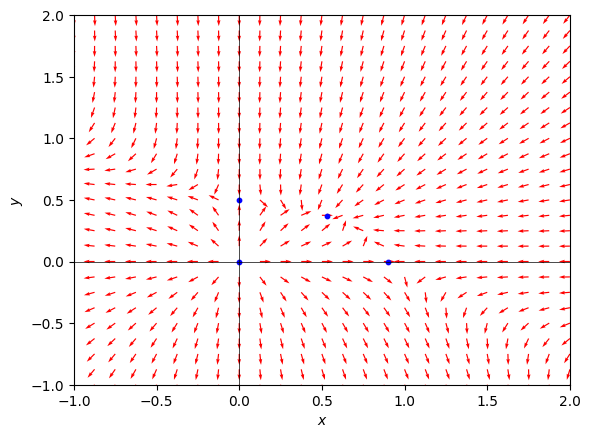

In [3]:
# Define the system of equations
Y, X = np.mgrid[-1:2:25j, -1:2:25j] 
U, V = lotka_volterra(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.9, 0, 8/15], [0, 0, 0.5, 11/30], color='blue', s=10) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-1, 2])  # x-axis limits include negative values
plt.ylim([-1, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

By plot(and we could further verify by checking the eigenvectors of Jacobian matrix near each equilibrium), we see that the actual boundary for the basin of attraction of $(\frac{8}{15}, \frac{11}{30})$ is the union of non-negative x-axis and y-axis. If an initial condition in first quadrant is close to axis, we could see that it is first attracted to one of the saddle, then move away from the saddle to be attracted by the nodal sink.

In this simple case, access to the ground truth of boundary makes it easier to collect datapoints: We generate the initial dataset by uniform sampling. If it is in the first quadrant, we give label +1, else label -1. We do not need to run numerical solver to check.

## Generate datasets

In [ ]:
# Generate 100,000 random data points in the space (-1, 2) * (-1, 2)
x = np.random.uniform(-1, 2, 100000)
y = np.random.uniform(-1, 2, 100000)

# Assign labels
labels = np.where((x > 0) & (y > 0), 1, -1)

# Combine x, y, and labels into a single dataframe with column labels
data = pd.DataFrame({'x0': x, 'y0': y, 'label': labels})

# Save data to a CSV file
data.to_csv("dataset_lv2d.csv", index=False)

We apply bisection routine to create another dataset of near-boundary points. We set the margin $\delta=0.01$.

In [ ]:
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if (c[0] > 0) & (c[1] > 0):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

In [ ]:
## Generate a dataset of near-boundary points
data = pd.read_csv("dataset_lv2d.csv")
data_1 = data[data['label'] == 1].sample(1000)
data_n1 = data[data['label'] == -1].sample(1000)

dataset_near = []
for i in range(len(data_1)):
    for j in range(len(data_n1)):
        a = (data_1.iloc[i]['x0'], data_1.iloc[i]['y0'])
        b = (data_n1.iloc[j]['x0'], data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])



In [ ]:
dataset_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'label'])
dataset_near.to_csv("dataset_lv2d_near.csv", index=False)

In [ ]:
df_near = pd.read_csv("dataset_lv2d_near.csv").sample(50000)
df_near.to_csv("dataset_lv2d_near_sample.csv", index=False)

## Model training

In [33]:
class LotkaVolterraDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y



dataset_uniform = LotkaVolterraDataset("dataset_lv2d.csv")
dataset_near = LotkaVolterraDataset("dataset_lv2d_near_sample.csv")

dataset_uniform_train, dataset_uniform_test = torch.utils.data.random_split(dataset_uniform, [80000, 20000])
dataset_near_train, dataset_near_test = torch.utils.data.random_split(dataset_near, [40000, 10000])
dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
dataset_merged_test = torch.utils.data.ConcatDataset([dataset_uniform_test, dataset_near_test])

In [34]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net = Net()

In [35]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude, threshold):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude
        self.threshold = threshold

    def forward(self, predictions, labels, inputs, b):
        l = nn.BCELoss()
        l = l(predictions.squeeze(), labels)

        near_condition = (predictions > 0.5 - self.threshold) & (predictions < 0.5 + self.threshold)
        near_points_prediction = predictions[near_condition]
        near_points_input = inputs[near_condition].clone().detach().requires_grad_(True)
        grads = torch.autograd.grad(near_points_prediction.sum(), near_points_input, create_graph=True, allow_unused=True)[0]
        
        if grads is not None:
            norm_grads = grads / grads.norm(dim = 1, keepdim=True)
            norm_b = b / b.norm(dim=1, keepdim=True)
            inner_product = (norm_grads * norm_b).sum(dim=1)
            inner_product = inner_product ** 2
            l += self.magnitude * inner_product
        
        return l

In [36]:
def train_model_bce(net, dataset_train, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net
    
def train_model_custom(net, dataset_train, batchsize, epochs, lr, magnitude, threshold):
    criterion = CustomLoss(magnitude, threshold)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, lotka_volterra(0, features.T))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net

def test_model(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()

    plt.hist(probability, bins=100)
    plt.show()

In [37]:
net_bce_uniform = Net()
net_bce_uniform = train_model_bce(net, dataset_uniform_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.060
Finished training for epoch 2, loss: 0.010
Finished training for epoch 3, loss: 0.006
Finished training for epoch 4, loss: 0.004
Finished training for epoch 5, loss: 0.003
Finished training for epoch 6, loss: 0.003
Finished training for epoch 7, loss: 0.003
Finished training for epoch 8, loss: 0.002
Finished training for epoch 9, loss: 0.002
Finished training for epoch 10, loss: 0.002


In [38]:
net_custom_uniform = Net()
net_custom_uniform = train_model_custom(net, dataset_uniform_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.002
Finished training for epoch 2, loss: 0.002
Finished training for epoch 3, loss: 0.002
Finished training for epoch 4, loss: 0.001
Finished training for epoch 5, loss: 0.001
Finished training for epoch 6, loss: 0.002
Finished training for epoch 7, loss: 0.001
Finished training for epoch 8, loss: 0.002
Finished training for epoch 9, loss: 0.001
Finished training for epoch 10, loss: 0.001


In [39]:
net_bce_near = Net()
net_bce_near = train_model_bce(net, dataset_near_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.101
Finished training for epoch 2, loss: 0.070
Finished training for epoch 3, loss: 0.058
Finished training for epoch 4, loss: 0.048
Finished training for epoch 5, loss: 0.043
Finished training for epoch 6, loss: 0.036
Finished training for epoch 7, loss: 0.033
Finished training for epoch 8, loss: 0.033
Finished training for epoch 9, loss: 0.031
Finished training for epoch 10, loss: 0.029


In [40]:
net_custom_near = Net()
net_custom_near = train_model_custom(net, dataset_near_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.025
Finished training for epoch 2, loss: 0.026
Finished training for epoch 3, loss: 0.023
Finished training for epoch 4, loss: 0.021
Finished training for epoch 5, loss: 0.022
Finished training for epoch 6, loss: 0.021
Finished training for epoch 7, loss: 0.021
Finished training for epoch 8, loss: 0.020
Finished training for epoch 9, loss: 0.018
Finished training for epoch 10, loss: 0.019


In [41]:
net_bce_merged = Net()
net_bce_merged = train_model_bce(net, dataset_merged_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.010
Finished training for epoch 2, loss: 0.009
Finished training for epoch 3, loss: 0.009
Finished training for epoch 4, loss: 0.009
Finished training for epoch 5, loss: 0.007
Finished training for epoch 6, loss: 0.008
Finished training for epoch 7, loss: 0.007
Finished training for epoch 8, loss: 0.007
Finished training for epoch 9, loss: 0.007
Finished training for epoch 10, loss: 0.007


In [42]:
net_custom_merged = Net()
net_custom_merged = train_model_custom(net, dataset_merged_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.007
Finished training for epoch 2, loss: 0.006
Finished training for epoch 3, loss: 0.006
Finished training for epoch 4, loss: 0.006
Finished training for epoch 5, loss: 0.006
Finished training for epoch 6, loss: 0.006
Finished training for epoch 7, loss: 0.006
Finished training for epoch 8, loss: 0.005
Finished training for epoch 9, loss: 0.005
Finished training for epoch 10, loss: 0.005


Accuracy: 1.0


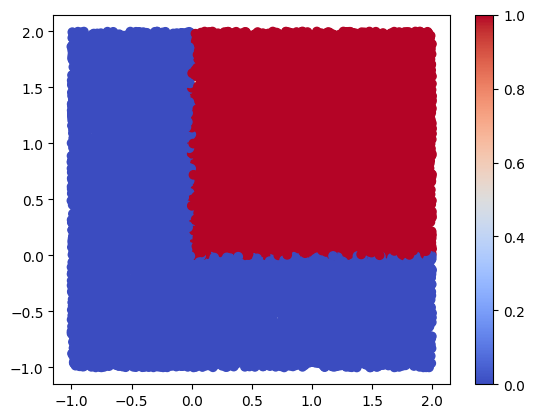

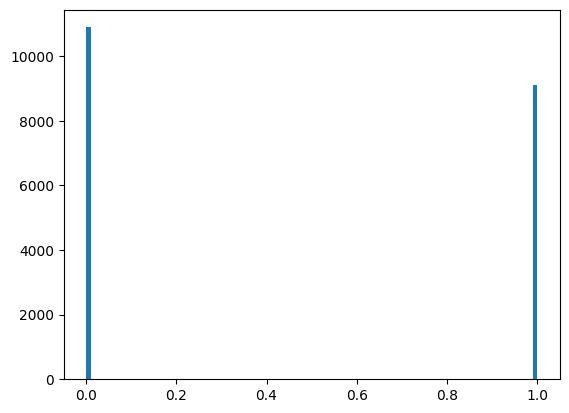

In [43]:
## net_bce_uniform
test_model(net_bce_uniform, dataset_uniform_test)

Accuracy: 0.9926000237464905


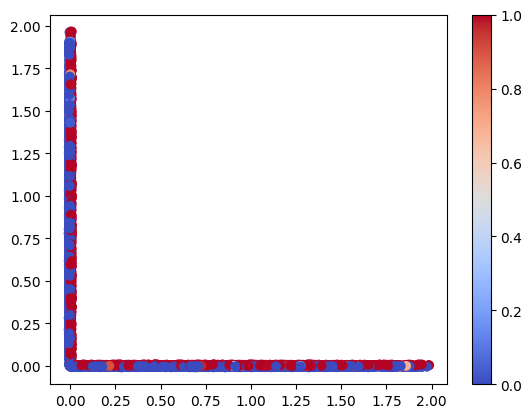

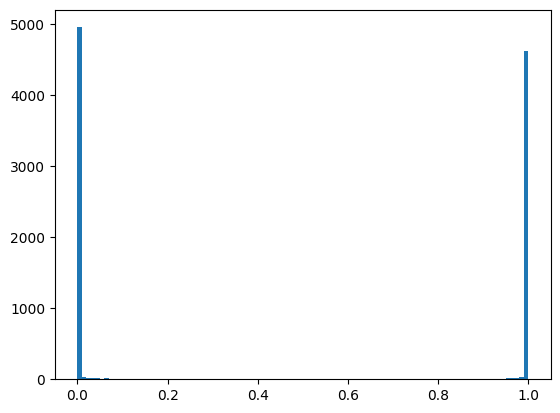

In [44]:
test_model(net_bce_uniform, dataset_near_test)

Accuracy: 0.9975333213806152


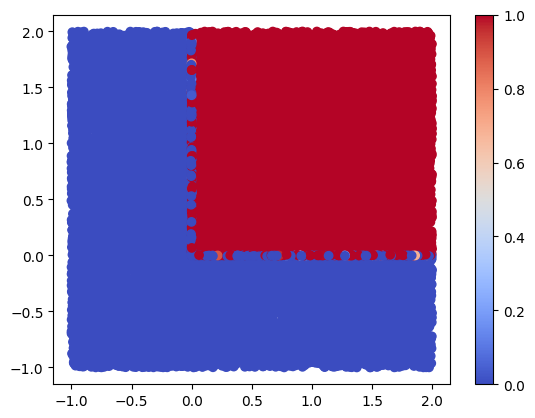

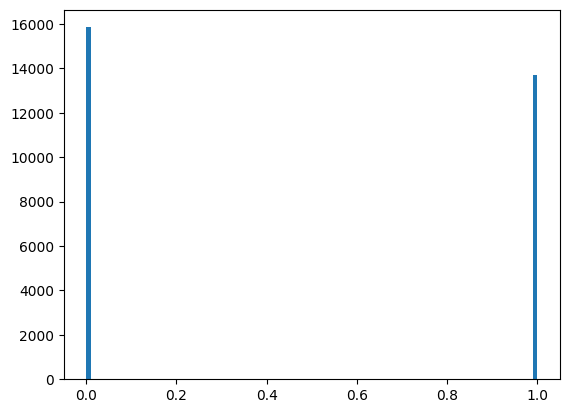

In [45]:
test_model(net_bce_uniform, dataset_merged_test)

Accuracy: 1.0


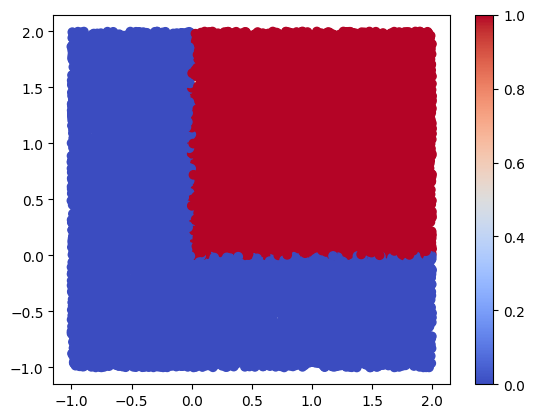

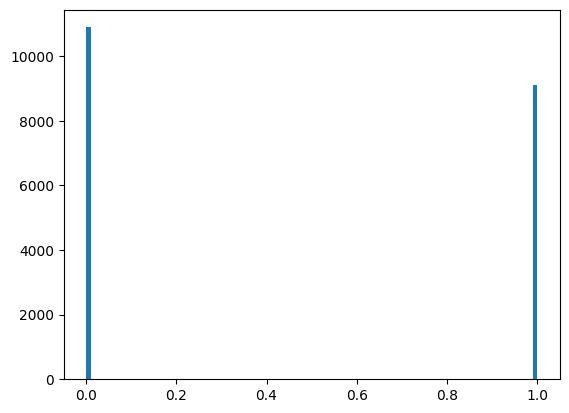

In [46]:
## net_custom_uniform
test_model(net_custom_uniform, dataset_uniform_test)

Accuracy: 0.9926000237464905


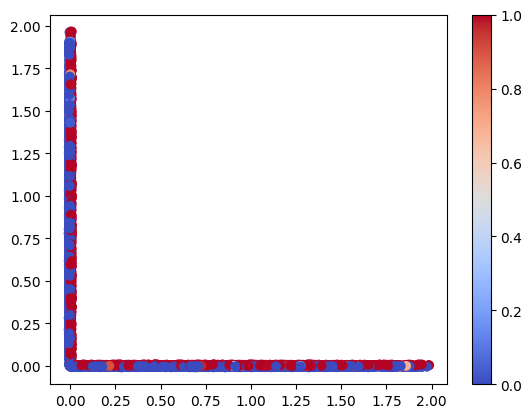

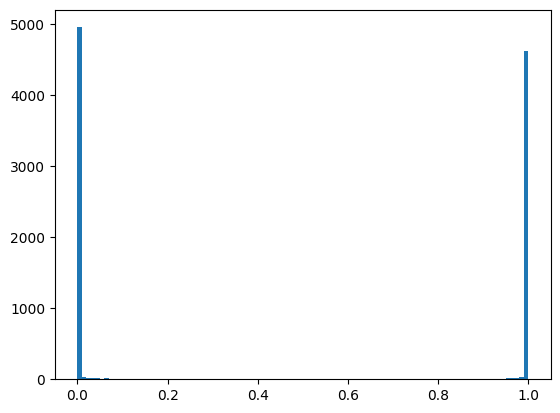

In [47]:
test_model(net_custom_uniform, dataset_near_test)

Accuracy: 0.9975333213806152


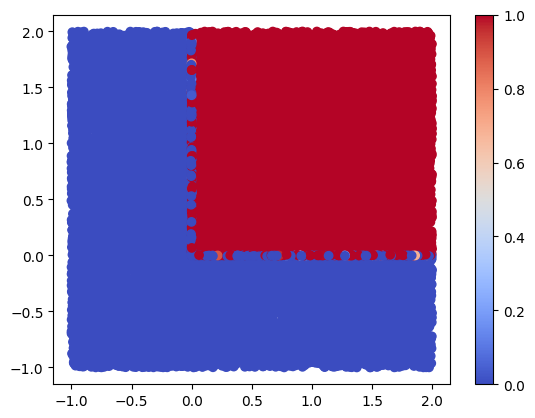

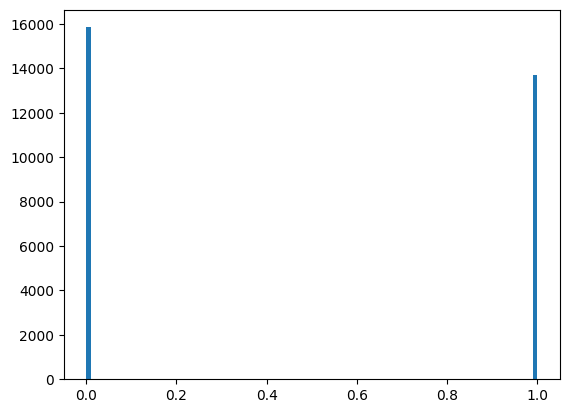

In [48]:
test_model(net_custom_uniform, dataset_merged_test)

Accuracy: 1.0


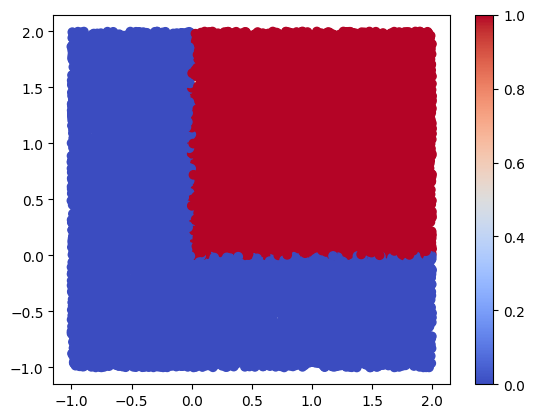

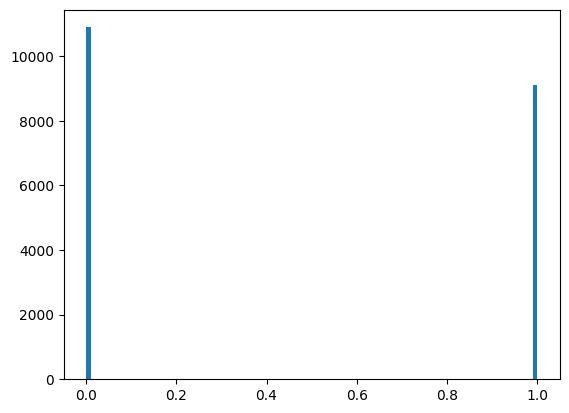

In [49]:
## net_bce_near
test_model(net_bce_near, dataset_uniform_test)

Accuracy: 0.9926000237464905


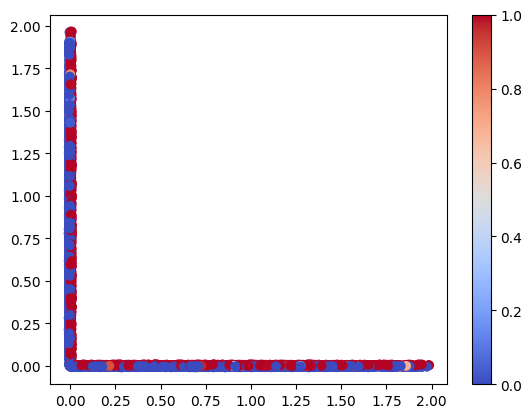

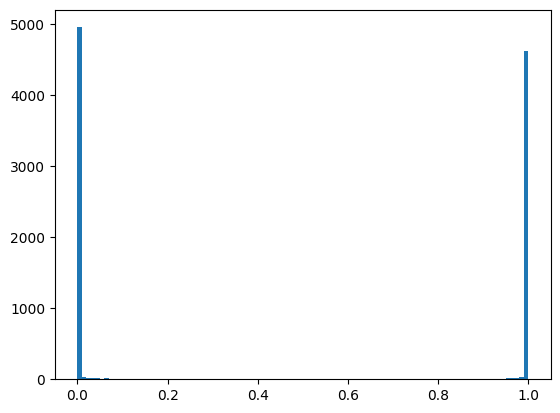

In [50]:
test_model(net_bce_near, dataset_near_test)

Accuracy: 0.9975333213806152


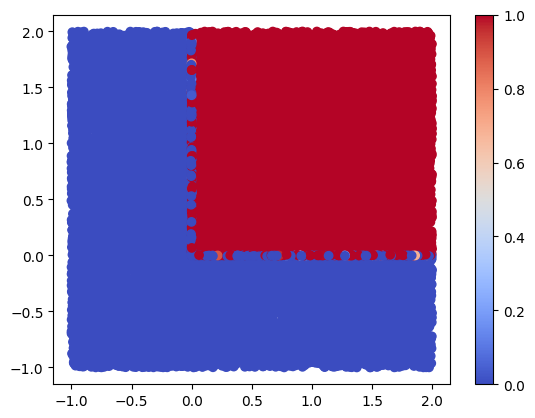

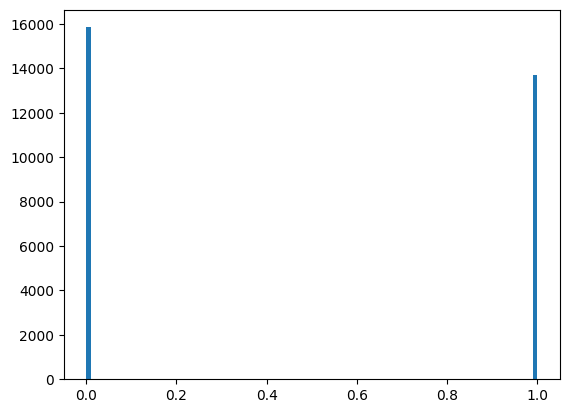

In [51]:
test_model(net_bce_near, dataset_merged_test)

Accuracy: 1.0


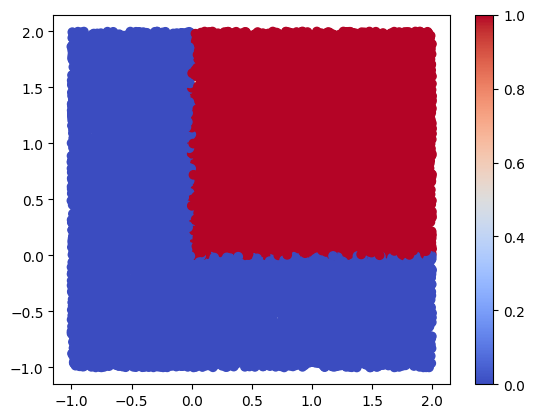

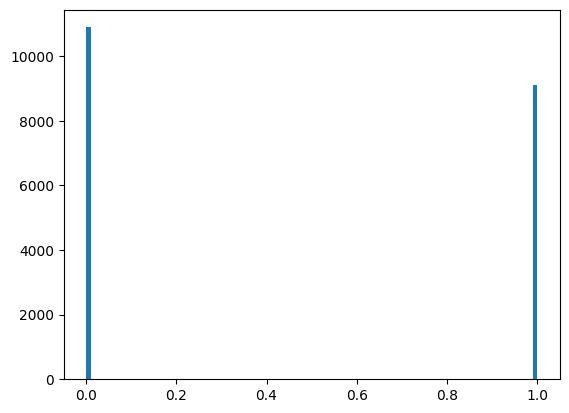

In [52]:
## net_custom_near
test_model(net_custom_near, dataset_uniform_test)

Accuracy: 0.9926000237464905


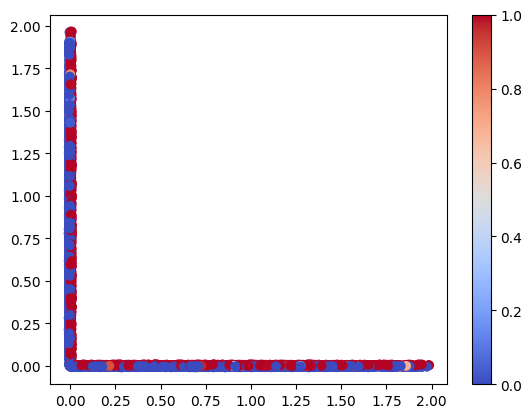

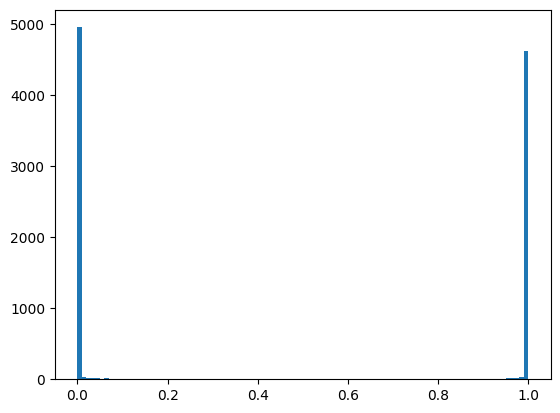

In [53]:
test_model(net_custom_near, dataset_near_test)

Accuracy: 0.9975333213806152


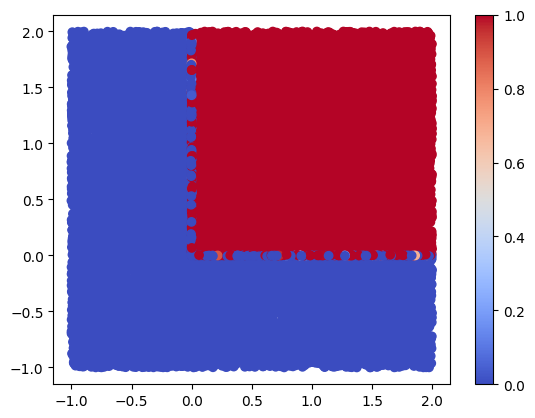

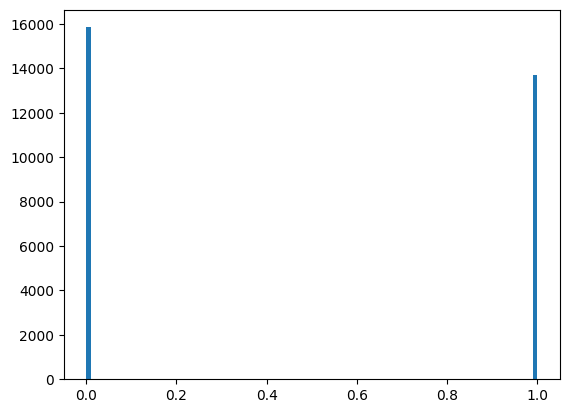

In [54]:
test_model(net_custom_near, dataset_merged_test)

Accuracy: 1.0


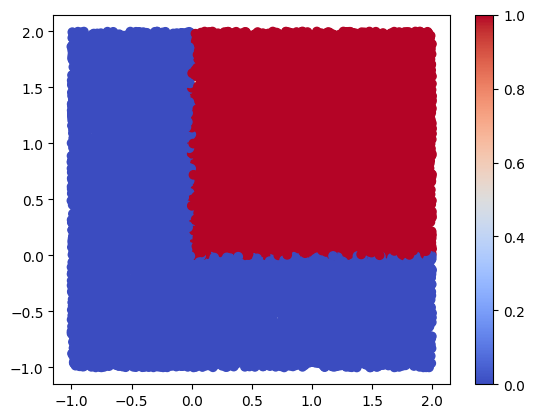

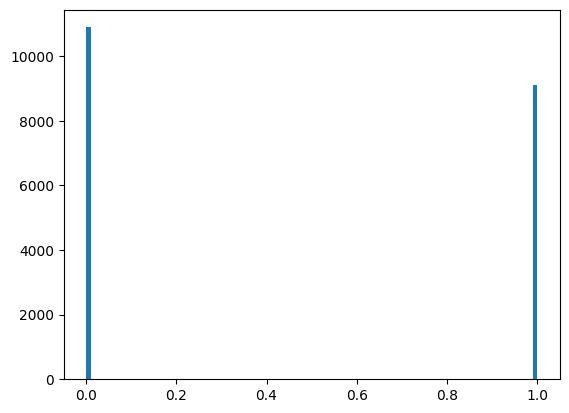

In [55]:
## net_bce_merged
test_model(net_bce_merged, dataset_uniform_test)

Accuracy: 0.9926000237464905


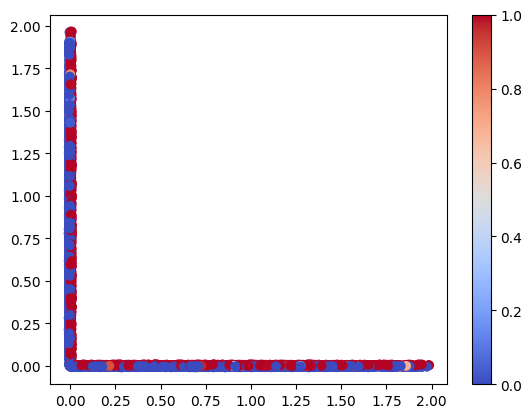

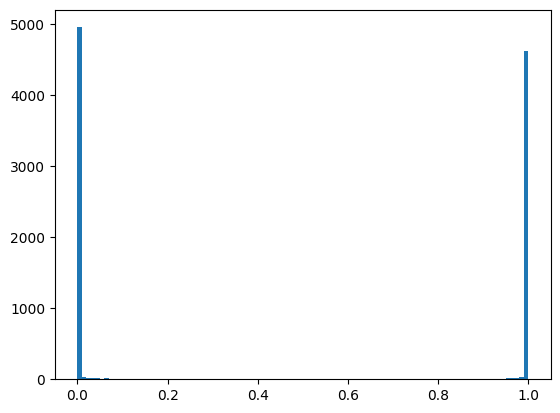

In [56]:
test_model(net_bce_merged, dataset_near_test)

Accuracy: 0.9975333213806152


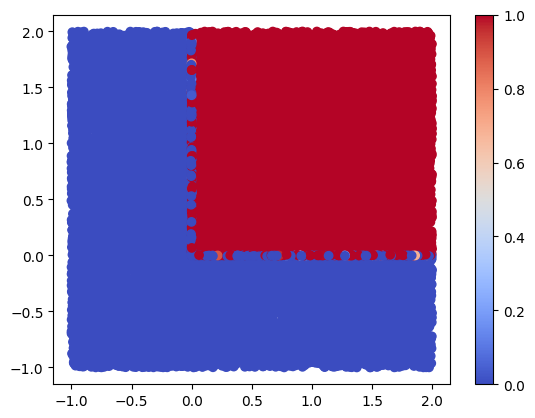

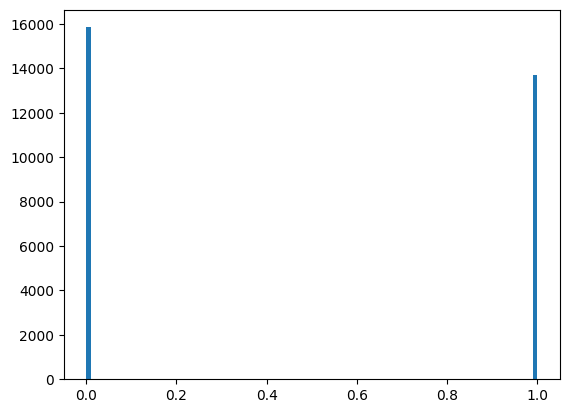

In [57]:
test_model(net_bce_merged, dataset_merged_test)

Accuracy: 1.0


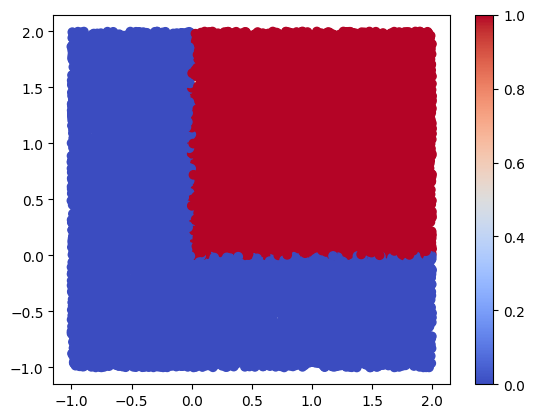

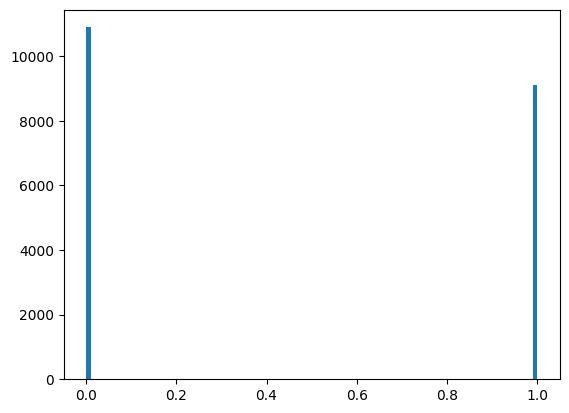

In [58]:
## net_custom_merged
test_model(net_custom_merged, dataset_uniform_test)

Accuracy: 0.9926000237464905


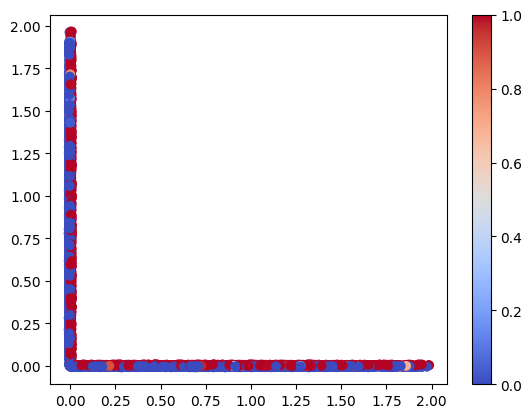

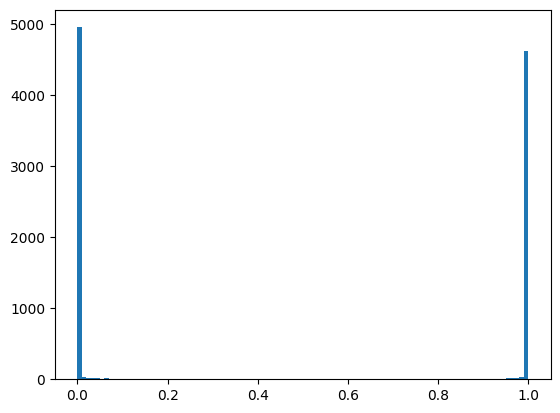

In [59]:
test_model(net_custom_merged, dataset_near_test)

Accuracy: 0.9975333213806152


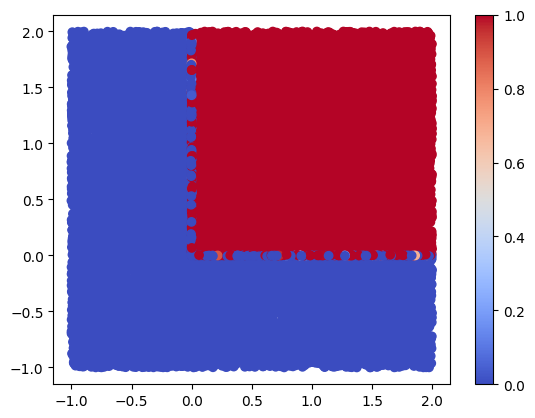

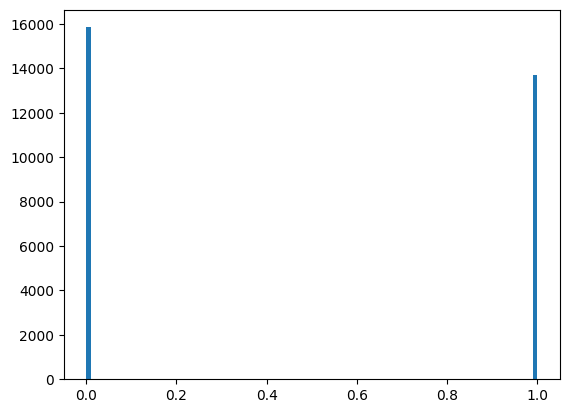

In [60]:
test_model(net_custom_merged, dataset_merged_test)